In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import math
import cv2
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings

# Plot style
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Model visualization
try:
    from tensorflow.keras.utils import plot_model
except ImportError:
    print("Warning: Unable to import plot_model from tensorflow.keras.utils. Please make sure to install the necessary dependencies for model visualization.")


# Data Loading

In [4]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 224
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 88.33it/s]


# Data Visualization

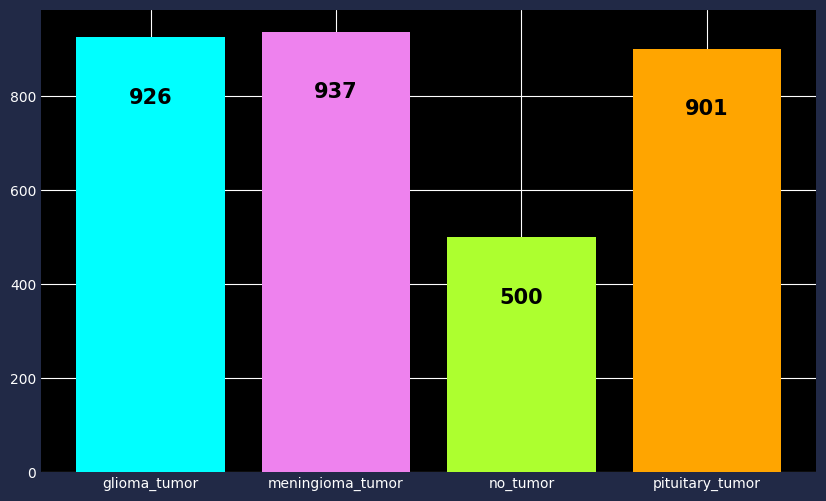

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(10, 6))
plt.style.use("dark_background")

# Define the unique classes in y_train
classes = np.unique(y_train)

# Define the colors for the classes
colors = ["aqua", "violet", "greenyellow", "orange"][:len(classes)]

# Calculate counts for each class
counts = [np.sum(y_train == label) for label in classes]

# Create the bar plot
plt.bar(classes, counts, color=colors, tick_label=classes)

# Annotate the bars
for label, count in zip(classes, counts):
    plt.annotate(int(count), xy=(label, count - 150),
                 rotation=0, color="black",
                 ha="center", verticalalignment='bottom',
                 fontsize=15, fontweight="bold")

# Show the plot
plt.show()

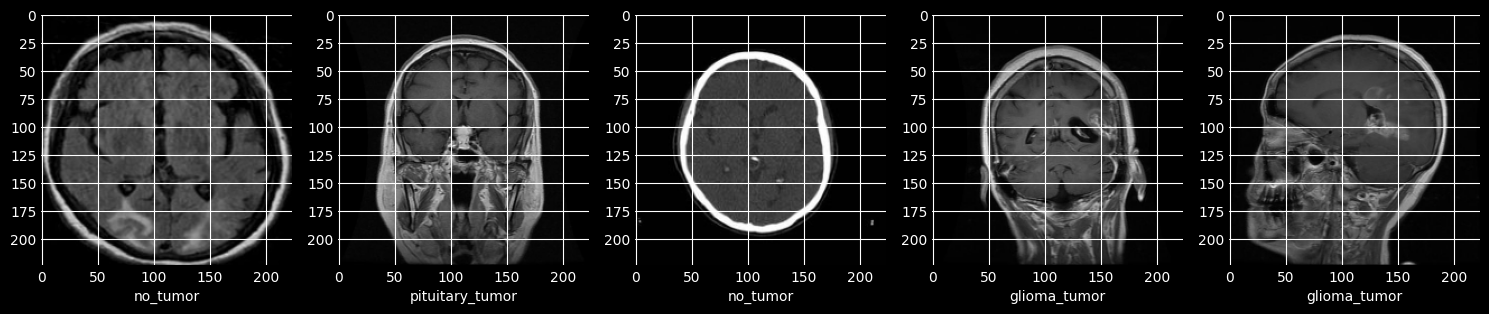

In [7]:
plt.figure(figsize=(15, 15))

random_indices = np.random.choice(len(X_train), size=5, replace=False) 
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.xlabel(y_train[idx])
    plt.tight_layout()
plt.show()

# Gray level histogram

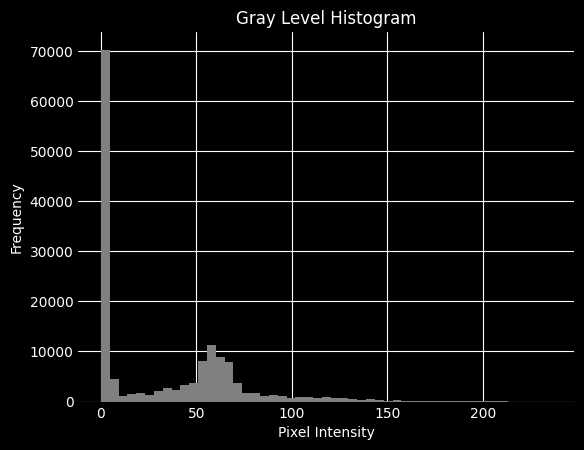

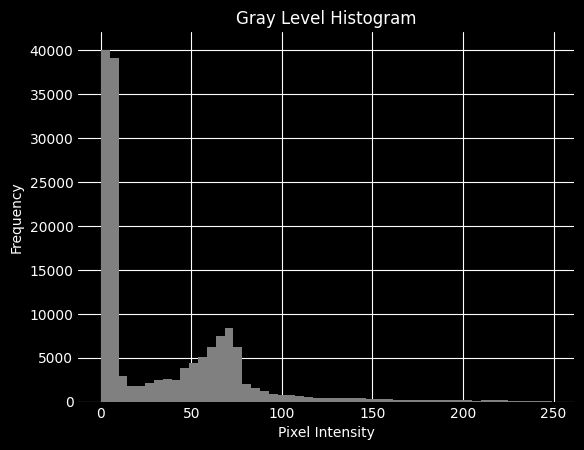

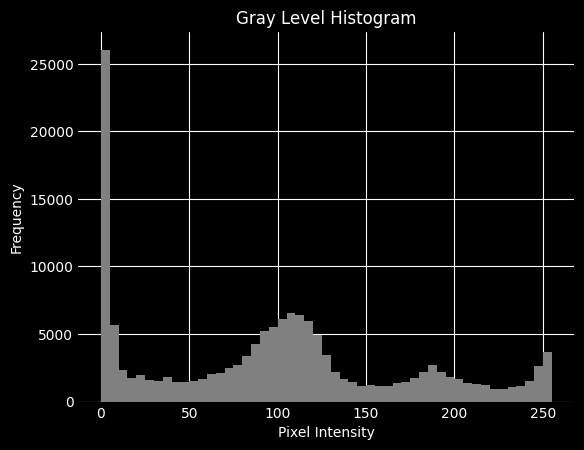

In [8]:
def gray_hist(image, bins=51):
    plt.hist(image.reshape((-1,)), bins, color='gray')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Gray Level Histogram')
    plt.show()

# Randomly select and display gray level histograms for three images
for _ in range(3):
    idx = random.randint(0, len(X_train) - 1)
    image = X_train[idx]
    gray_hist(image)

# Image Prepration

In [3]:
import os
import cv2
import glob
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import skimage.measure   
import tensorflow as tf
from skimage import data
import albumentations as A
import scipy.ndimage as ndi
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from tensorflow.keras import regularizers
from skimage.measure.entropy import shannon_entropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization

In [4]:
#Train
train_glioma = glob.glob('/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor/*.jpg')
train_menignioma = glob.glob('/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor/*.jpg')
train_pituitary = glob.glob('/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor/*.jpg')
train_no = glob.glob('/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/*.jpg')

#Test
test_glioma = glob.glob('/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/*.jpg')
test_menignioma = glob.glob('/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/*.jpg')
test_pituitary = glob.glob('/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor/*.jpg')
test_no = glob.glob('/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor/*.jpg')

In [5]:
train_glioma_number = len(train_glioma)
train_menignioma_number = len(train_menignioma)
train_pituitary_number = len(train_pituitary)
train_no_number = len(train_no)

test_glioma_number = len(test_glioma)
test_menignioma_number = len(test_menignioma)
test_pituitary_number = len(test_pituitary)
test_no_number = len(test_no)

print("Number of train_glioma: ",train_glioma_number)
print("Number of train_menignioma: ",train_menignioma_number)
print("Number of train_pituitary: ",train_pituitary_number)
print("Number of train_no: ",train_no_number)
print("Number of test_glioma: ",test_glioma_number)
print("Number of test_menignioma: ",test_menignioma_number)
print("Number of test_pituitary: ",test_pituitary_number)
print("Number of test_no: ",test_no_number)

Number of train_glioma:  826
Number of train_menignioma:  822
Number of train_pituitary:  822
Number of train_no:  395
Number of test_glioma:  100
Number of test_menignioma:  115
Number of test_pituitary:  74
Number of test_no:  105


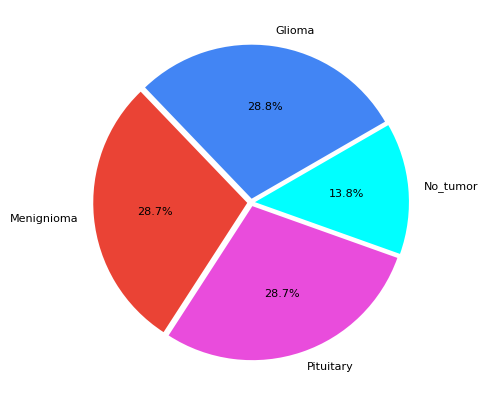

In [6]:
plt.figure(figsize=(5,5))
colors = ['#4285f4','#ea4335',"#e94cdc","#00FFFF"]
plt.rcParams.update({'font.size': 8})
plt.pie([train_glioma_number,
         train_menignioma_number,train_pituitary_number,train_no_number],
        labels=['Glioma', 'Menignioma','Pituitary','No_tumor'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

Pie-chart of the Test image

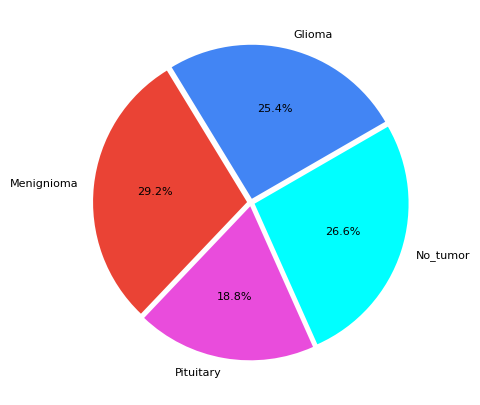

In [7]:
plt.figure(figsize=(5,5))
colors = ['#4285f4','#ea4335',"#e94cdc","#00FFFF"]
plt.rcParams.update({'font.size': 8})
plt.pie([test_glioma_number,
         test_menignioma_number,test_pituitary_number,test_no_number],
        labels=['Glioma', 'Menignioma','Pituitary','No_tumor'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

Pie-chart of the Test and Train image

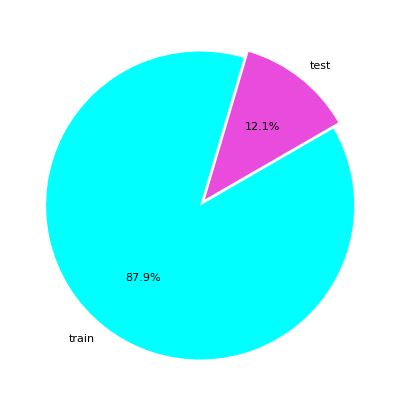

In [8]:
plt.figure(figsize=(5,5))
colors = ["#e94cdc","#00FFFF"]
plt.rcParams.update({'font.size': 8})
plt.pie([test_glioma_number+
         test_menignioma_number+test_pituitary_number+test_no_number,train_glioma_number+
         train_menignioma_number+train_pituitary_number+train_no_number],
        labels=['test', 'train'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025),
        startangle=30);